# Carbon prices and forest preservation over space and time in the Brazilian Amazon


In [1]:
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
!pip install casadi
from casadi import *
from scipy.linalg import logm, expm
from IPython.display import display, Markdown
import time
import math
import itertools
import os
import sys
!git clone https://github.com/Finalblue777/amazon_mhpy
workdir = os.getcwd() + '/amazon_mhpy/'
sys.path.insert(0, workdir)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


fatal: destination path 'amazon_mhpy' already exists and is not an empty directory.


# 1 Model
---
## 1.1 State Variable
Let us begin with a definition of the important state vectors
\begin{array}{llll}
Z_t &  := & (Z_t^1, Z_t^2, ..., Z_t^I) & \textrm{ vector of area used for agriculture expressed in hectares} \cr
X_t & := & (X_t^1, X_t^2, ..., X_t^I) & \textrm{ vector of carbon captured expressed in Mg CO2e (CO2 equivalent)  } \cr
A_t & := & (A_t^1, A_t^2, ..., A_t^I) & \textrm{ vector of agricultural output}
\end{array}
where
$$
0 \le Z_t^i \le {\bar z}_i
$$
and define
$$
\tilde X_t = \sum_i^I X_t^i
$$

In [2]:
#Site Data
# Read data file
n='global'
file=workdir + f"data/calibration_{n}Model.csv"
df = pd.read_csv(file)
df = df.sort_values(by=[f'theta_{n}'])

z0_list = df[f'z_2017_{n}'].to_numpy() # initial distribution of agriculture
γ_list  = df[f'gamma_{n}'].to_numpy()  #  the amount of carbon (aka impact of cutting down forests)
x0_list = γ_list * (df[f'forestArea_2017_ha_{n}'].to_numpy())# initial distribution of carbon absoprtion of the amazon
θ_list  = df[f'theta_{n}'].to_numpy() #  distribution of the productivity parameters

# Parameter values
normalization_value = 1e9 # normalization value
α = 0.045007414 # mean-reverting coefficient

Z0_list = z0_list/ normalization_value
X0_list = x0_list/ normalization_value

z̄ = (df[f'zbar_2017_{n}'].to_numpy() )/normalization_value # distribution of the upper bound of agriculture in each site
n = len(z̄) # total number of sites

Let us define the state variable vector

$$
Y_t = \begin{bmatrix}
Z^1_t\\
Z^2_t\\
\vdots\\
Z^I_t\\
\tilde X_t\\
1
\end{bmatrix}
$$

where we have the following laws of motion

$$
\begin{equation}
\begin{aligned}
\dot{X}_t^i&=-\gamma^i U_t^i-\alpha\left[X_t^i-\gamma^i\left(\bar{z}^i-Z_t^i\right)\right]\\
&=-\gamma^i U_t^i-\alpha X_t^i+\alpha\gamma^i\bar{z}^i-\alpha\gamma^i Z_t^i
\end{aligned}
\end{equation}\tag{1}
$$

$$
\dot Z_t^i = U_t^i - V_t^i \tag{2}
$$

where $U_t^i \geq 0$ and $V_t^i \geq 0$ are controls and it is useful to define

$$
U_t^i :=(U_t^1, U_t^2, ..., U_t^I)  \textrm{ vector increases in agriculture}
$$
**The site-specific parameter $γ^i \geq 0$ denotes
the density of CO2e that is present in a primary forest in site $i$.**

We can rewrite the law of motion into the following
$$
\dot Y_t = A Y_t + B \dot Z_t +D U_t
$$
The codes define the matrices $A$, $B$ and $D$ below

$$
A := \begin{bmatrix}
0 & 0 & 0 & \dots & 0 & 0  & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots  &\vdots  &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
-\alpha \gamma^1 & -\alpha \gamma^2 & -\alpha \gamma^3 & \dots & -\alpha \gamma^I & -\alpha  & \alpha \sum_i \gamma^i \bar z^i\\
0 & 0 & 0 & \dots & 0 & 0  & 0
\end{bmatrix}
$$

In [3]:
#Construct Matrix A
Az = np.zeros((n, n+2))

Ax = np.zeros((1, n+2-0))
Ax[0,0:n-0] = -α *γ_list[0:n]
Ax[0, -1] = np.sum(α*γ_list[0:n] * z̄[0:n])
Ax[0,-2]  = -α

A  = np.concatenate((Az, Ax, np.zeros((1, n+2-0))), axis=0)

The code below define the matrix of $B$, which is the following

$$
B = \begin{bmatrix}
1 & 0 & 0 & \dots & 0 & 0 & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 1\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
0 & 0 & 0 & \dots & 0 & 0 & 0
\end{bmatrix}
$$

In [4]:
# Construct Matrix B
Bz = np.identity((n-0))
Bx = (np.zeros((1,n-0)))

B  = np.concatenate((Bz, Bx,  np.zeros((1, n-0))), axis=0)

The code below defines the matrix of $D$, which si the following
$$
D := \begin{bmatrix}
0 & 0 & 0 & \dots & 0 & 0 & 0\\
\vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 0\\
-\gamma_1 & -\gamma_2 & -\gamma_3 & \dots & -\gamma_{I-2} & -\gamma_{I-1} & -\gamma_{I}\\
0 & 0 & 0 & \dots & 0 & 0 & 0
\end{bmatrix}
$$

In [5]:
# Construct Matrix B
Dz =   np.zeros((n-0,n-0))
Dx = -(np.ones((1,n-0))*γ_list[0:n])

D  = np.concatenate((Dz, Dx, np.zeros((1, n-0))), axis=0)

Below defines the discretize law of motion, we discretize in the following way

$$
\dot Y_t = A Y_t + B \dot Z_t +D U_t \implies Y_{t+dt} = \left(A Y_t + B \dot Z_t + D U_t \right)dt+ Y_t
$$

In [6]:
y  = MX.sym('Y',n+2) # state
u = MX.sym('u',n) # positive control
v = MX.sym('u',n) # negative control

rhs = sparsify(A)@ y + sparsify(B)@(u-v) + sparsify(D)@(u) + y # dynamics
F = Function('f', [y, v, u],[rhs]) # dynamics function

## 1.2 Objective Function
We define the cattle output as
$A_t^i=\theta^i Z_t^i$.
where **$θ_i$ is a site-specific productivity parameter**.

All of the locations contribute to emissions via the capture of carbon and emissions that result because of agricultural activity with a net impact given by
$$
\kappa \sum_{i=1}^I Z_t^i-\sum_{i=1}^I \dot{X}_t^i
$$
where the parameter $\kappa$ captures the emissions that result because of cattle farming. We include a cost of adjustment to changes in the use of land with contributions from each site. It is measured by
$$
\frac{\zeta}{2}\left[\sum_i^i\left(U_t^i+V_t^i\right)\right]^2
$$

Since many carbon trading schemes are based on emissions, we assume that the planner takes as given a price for carbon emissions $P^e$, the initial price for agriculture and the Markov process that describes the future evolution of the price $P_t^a$ for cattle and maximizes
$$
\mathbb{E}\left\{\int_0^{\infty} \exp (-\delta t)\left[-P^e\left(\kappa \sum_{i=1}^I Z_t^i-\sum_{i=1}^I \dot{X}_t^i\right)+P_t^a \sum_i \theta^i Z_t^i-\frac{\zeta}{2}\left[\sum_i^i\left(U_t^i+V_t^i\right)\right]^2\right] d t\right\}
$$
subject to equations (1)-(2), and the control restrictions:
$$
U_t^i \geqslant 0, \quad V_t^i \geqslant 0 \quad t \geqslant 0 .
$$
where $\delta$ is the subjective discount rate. The emission price $P^e$ considered by the planner would be the sum of the (constant) marginal value attributed by the planner to emission and any monetary transfers obtained from others, such as sales in carbon emission markets. In future work we intend to make $P^e$ a state variable.

For simplicity, we take $P^e$ to be independent of calendar time.

## 1.3 Calibration

In [7]:
# Parameter values
normalization_value = normalization_value
δ = 0.02
α = α
κ = 2.094215255
Pe = 0
ζ = 1.66e-4 * normalization_value
Pa_1 = 38.29988757
Pa_2 = 44.75876047

# Parameters
parameters = [
    ("","normalization", normalization_value),
    ("δ","discount rate", δ),
    ("α", "mean-reversion coefficient",α),
    ("κ", "emission rate", κ),
    ("$P^e$", "price of emission", Pe),
    ("ζ", "adjustment cost",ζ),
    ("$P^a_1$", "low price of agriculture",Pa_1),
    ("$P^a_2$", "high price of agriculture",Pa_2)
]


# Generate Markdown table
markdown_table = "| Parameter | Explaination|Value |\n|---|---|---|\n"
for param, name,value in parameters:
    markdown_table += f"| {param} | {name} | {value} |\n"

# Display the Markdown table
display(Markdown(markdown_table))


| Parameter | Explaination|Value |
|---|---|---|
|  | normalization | 1000000000.0 |
| δ | discount rate | 0.02 |
| α | mean-reversion coefficient | 0.045007414 |
| κ | emission rate | 2.094215255 |
| $P^e$ | price of emission | 0 |
| ζ | adjustment cost | 166000.0 |
| $P^a_1$ | low price of agriculture | 38.29988757 |
| $P^a_2$ | high price of agriculture | 44.75876047 |


## 1.3 Time and Discounting
We define:

$T$ to be the time horizon
$N$ to be the number of controls
$T_u$ to be the stochastic horizon

$dt = T/N$ to be the time step

Below we also construct a vector of discount rates in the following way

\begin{align*}
\text{discount_vector[i]} = \exp(-\delta i \cdot \text{{dt}})
\end{align*}

In [8]:
T   = 200 # time horizon
N   = T # number of control intervals
T_u = 5 # stochastic horizon

dt = T/N # time step

ds_vect = np.zeros((N+1,1))
for i in range(N+1):
    ds_vect[i]=math.exp(-δ*i*dt)

## 1.4 Computation of Price and Probability Matrices with Markov Chain Transitions

The provided Python code has the following steps:

1. **Transition Matrix and Instantaneous Generator:** It first defines a transition probability matrix `P`, and then calculates an instantaneous generator `M` using the logarithm of the matrix `P` divided by a time step `dτ`. It then calculates `m1` and `m2` as the off-diagonal elements of `M`. Finally, it computes a new transition matrix `P` by taking the matrix exponential of `M` multiplied by a time step `dt`.

2. **Markov Array Generation:** The code generates a `Markov array` that contains all possible sequences of 0s and 1s of length `T_u + 1`. This is done using the `itertools.product` function, which computes the Cartesian product of `[0, 1]` repeated `T_u + 1` times.

3. **Price Matrix Initialization and Filling:** It initializes a `price matrix` that has the same number of rows as the Markov array and `T+1` columns. The matrix is filled with zeros initially. The first `T_u + 1` columns of the price matrix are filled with the Markov array. The remaining columns are filled with the last column of the Markov array, utilizing NumPy's broadcasting feature.

4. **Price Matrix Adjustment:** All zeros in the price matrix are replaced with the value `p1`, and all ones are replaced with `p2`.

5. **Probability Matrix Initialization and Calculation:** A `probability matrix` is initialized with the same number of rows as the Markov array and one column. For each row of the Markov array, the code computes a probability that corresponds to the sequence of 0s and 1s in that row. This probability is calculated as the product of transition probabilities from the `P` matrix for each pair of adjacent elements in the sequence. The computed probability is stored in the corresponding row of the probability matrix.

The `P` matrix is now a 2x2 NumPy array where `P[i, j]` is the transition probability from state i to state j. The script uses the zip function to pair each element of the sequence with its next neighbor, representing state transitions, and calculates the product of the corresponding transition probabilities using the numpy.prod function.

This code makes use of NumPy's built-in array operations for efficiency and minimizes the use of Python loops. However, it might be slow if `T_u + 1` is large due to the exponential increase in the number of unique sequences with `T_u + 1`.


In [9]:
# Step 1: Formalize transition matrix and instantenous generator
dτ = 1/12  # time step
P = np.matrix([[0.982758621, 0.017241379],[0.012578616, 0.987421384]])  #probability transition matrix
M = logm(P)/dτ  # instantenous generator
m1 = M[0,1]
m2 = M[1,0]

P = expm(M*dt)  # Updated Probability transition matrix

# Step 2: Generate markov array
markov_array = np.array(list(itertools.product([0, 1], repeat=T_u+1)))

# Step 3: Price matrix initialization and filling
price_matrix = np.zeros((len(markov_array),T+1))
price_matrix[:, 0:T_u+1] = markov_array                  # Uncertainty horizon
price_matrix[:,T_u+1:] = markov_array[:,-1, np.newaxis]  # Broadcasting to determinstic horizon

# Step 4: Price matrix adjustment
price_matrix[price_matrix==0] = Pa_1
price_matrix[price_matrix==1] = Pa_2

# Step 5: Probability matrix initialization and filling
prob_matrix = np.zeros((2**(T_u+1),1))
P = np.array([[P[0,0], P[0,1]], [P[1,0], P[1,1]]])
for i, row in enumerate(markov_array):
    # The zip function pairs adjacent elements together
    transitions = zip(row[:-1], row[1:])
    prob_temp = np.prod([P[x, y] for x, y in transitions])
    prob_matrix[i] = prob_temp # Note that the sum of prob_matrix would be 2, because we consider two cases for the initial price

# 2 Finite Horizon Optimization
---

## 2.1 Function `state_constructor(opti, T_u)`
This function sets up and constructs decision variables and constraints for an optimization problem.

### Parameters
- `opti`: An instance of an optimization problem.
- `T_u`: A parameter used to define the range of our loops in the function.

### Steps

1. **Initialization of Variables**: Four empty lists `V`, `U`, `ZO`, and `Y` are initialized. These lists will be used to store decision variables for the states, where
$$ZO = \left[\sum_i (U_t^i+V_t^i)\right]^2$$

2. **Variables Definition**: A loop runs `2**T_u` times. In each iteration, it adds new variables to each of the lists.

3. **Constraints Definition**: The function then defines a set of constraints. These constraints forces the (k+1)th column of the ith Y variable to be equal to the output of the function `F`, applied to the kth column of the ith Y, V, and U variables. Then, each ZO variable equals the square of the sum of the corresponding U and V variables. A parameter `ic` is also defined and used to set another constraint where the first column of each Y variable equals to `ic`.

4. **Applying Constraints**: Finally, the function applies constraints on each decision variable. These constraints ensure that the first `n` rows of the `ith` Y variable and all rows of the `ith` V and U variables are greater than or equal to `0`, and less than or equal to `z̄` (for Y) or infinity (for V and U).

5. **Return Statement**: The function ends by returning all decision variables and the parameter `ic`.



In [10]:
def state_constructor(opti, T_u):
    # This function constructs the decision variables and constraints for an optimization problem.

    # Decision variables for states
    V = []  # List to store variables V
    U = []  # List to store variables U
    ZO = []  # List to store variables ZO
    Y = []  # List to store variables Y

    # The loop runs for 2 to the power of T_u times.
    # In each iteration, it adds new variables to the lists V, U, ZO, and Y.
    for p in range(2**(T_u)):
        U.append(opti.variable(n, N))
        V.append(opti.variable(n, N))
        ZO.append(opti.variable(1, N))
        Y.append(opti.variable(n+2, N+1))

    # Loop to define constraints based on function F.
    # For each i, for each k, the (k+1)th column of the ith Y variable
    # is constrained to be equal to the function F applied to the kth column of the ith Y, V, and U variables.
    for i in range(2**(T_u)):
        for k in range(N):
            opti.subject_to(Y[i][:,k+1] == F(Y[i][:,k], V[i][:,k], U[i][:,k]))

    # Constraint: Each ZO variable is equal to the square of the sum of the corresponding U and V variables.
    # Sum1 is the sum over the sites (row)
    for p in range(2**(T_u)):
        opti.subject_to(ZO[p] == sum1(U[p]+V[p])**2 )

    # Define a parameter 'ic' with dimension n+2 x 1
    ic = opti.parameter(n+2,1)

    # Constraint: The first column of each Y variable is equal to the initial condition.
    for i in range(2**(T_u)):
        opti.subject_to(Y[i][:,0] == ic)

    # Bound constraints: For each i, the first n rows of the ith Y variable, and all rows of the ith V and U variables,
    # are constrained to be between 0 and z̄ (for Y) or infinity (for V and U).
    for i in range(2**(T_u)):
        opti.subject_to(opti.bounded(0, Y[i][0:n,:], z̄))
        opti.subject_to(opti.bounded(0, V[i], inf))
        opti.subject_to(opti.bounded(0, U[i], inf))

    # Return all the decision variables and the parameter.
    return Y, U, V, ZO, ic

opti = casadi.Opti()
Y, U,V, ZO, ic  = state_constructor(opti, T_u)

## 2.2 Function `objective_constructor(p, prob_matrix, N_u, ZO, Y)`

This function constructs the objective function for an optimization problem.

### Parameters
- `p`: A given price.
- `prob_matrix`: A matrix containing the calculated probabilities.
- `N_u`: A parameter used to define the length of vectors in the function.
- `ZO`: List of decision variables.
- `Y`: List of decision variables.

$$
\mathbb{E}\left\{\int_0^{\infty} \exp (-\delta t)\left[
\underbrace{-\frac{\zeta}{2}\left[\sum_i^i\left(U_t^i+V_t^i\right)\right]^2}_{\text{term 1}}+\underbrace{ P^e \sum_{i=1}^I \dot{X}_t^i }_{\text{term 2}}\underbrace{-P^e \kappa \sum_{i=1}^I Z_t^i+P_t^a \sum_i \theta^i Z_t^i}_{\text{term 3}}\right] d t\right\}
$$

### Steps

1. **Initialization**: The function starts by initializing the objective to `0` and a counter `j` to `0`.

2. **Pre-calculation**: To optimize the function, some quantities that will be reused in the loop are pre-calculated. This includes a ones matrix of size `(1, 25)` and the transpose of a slice of the `ds_vect` vector.

3. **Loop**: The function then enters a loop that iterates `2**T_u` times. In each iteration, it checks if the first element of the `ith` row of `price_matrix` is equal to `p`. If true, it computes several quantities using the `jth` Z and Y variables, multiplies these quantities by the `ith` probability from `prob_matrix`, and adds the result to the objective. After each successful operation, `j` is incremented.

4. **Return Statement**: After the loop finishes, the function returns the computed objective.


In [11]:
def objective_constructor(p, prob_matrix, T_u, ZO, Y ) :
    objective = 0
    j=0

    # Sum1 is the sum over the sites (row)
    # Sum2 is the sum over the sites (column)
    for i in range(2**(T_u+1)):
        if price_matrix[i,0] == p:

            term_1 = sum2(ds_vect[0:N,:].T*(ZO[j]* ζ/2 ))
            term_2 = - sum2(ds_vect[0:N,:].T*(Pe*Y[j][-2,1:] - Pe*Y[j][-2,0:-1]  ))
            term_3 = - sum1(sum2(ds_vect.T*(price_matrix[i:i+1,:]*θ_list - Pe*κ )*Y[j][0:n,:]))

            objective = objective +  prob_matrix[i,0]*(term_1 + term_2 + term_3)
            j=j+1
    return objective

objective=objective_constructor(Pa_2, prob_matrix, T_u, ZO, Y)

## 2.3 Performing Finite Horizon Optimization using Casadi

In [12]:
opti.minimize(objective)

# solve optimization problem
options = dict()
options["print_time"] = True
options["expand"]     = True
options["ipopt"]      = {
                    'print_level': 5,
                    'fast_step_computation':            'yes',
                    'mu_allow_fast_monotone_decrease':  'yes',
                    'warm_start_init_point':            'yes',
                        }
opti.solver('ipopt',options)

t1 = time.time()
opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
sol = opti.solve()
disp(f'Initial, time: {time.time()-t1}')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality c

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7316066e+03 1.26e-03 2.83e-08  -2.5 2.28e+02    -  1.00e+00 1.00e+00h  1
  11 -4.9978268e+02 2.59e+00 5.01e-02  -3.8 8.73e+03    -  8.79e-01 1.00e+00f  1
  12 -5.0317339e+02 4.71e-01 1.50e-09  -3.8 3.72e+03    -  1.00e+00 1.00e+00h  1
  13 -6.2411623e+02 7.50e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1
  14 -6.2124808e+02 2.04e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1
  15 -6.2123154e+02 1.68e-06 1.50e-09  -3.8 7.04e+00    -  1.00e+00 1.00e+00h  1
  16 -1.0286335e+03 1.25e-01 8.19e-03  -5.7 2.10e+03    -  8.42e-01 9.13e-01f  1
  17 -1.0912362e+03 4.31e-02 1.38e-02  -5.7 1.08e+03    -  7.88e-01 9.35e-01h  1
  18 -1.1027869e+03 9.80e-03 1.85e-11  -5.7 5.36e+02    -  1.00e+00 1.00e+00h  1


  19 -1.1056712e+03 2.12e-03 1.84e-11  -5.7 2.48e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1055770e+03 1.16e-04 1.84e-11  -5.7 5.85e+01    -  1.00e+00 1.00e+00h  1
  21 -1.1055760e+03 4.41e-07 1.84e-11  -5.7 3.60e+00    -  1.00e+00 1.00e+00h  1
  22 -1.1124406e+03 1.39e-03 5.96e-04  -8.6 2.33e+02    -  8.28e-01 8.61e-01f  1
  23 -1.1135194e+03 6.76e-04 7.66e-04  -8.6 1.20e+02    -  7.03e-01 7.60e-01h  1


  24 -1.1138094e+03 2.78e-04 5.56e-04  -8.6 4.31e+01    -  7.39e-01 8.01e-01h  1
  25 -1.1138797e+03 9.67e-05 5.26e-05  -8.6 1.25e+01    -  9.06e-01 8.71e-01h  1
  26 -1.1138969e+03 2.75e-05 5.08e-13  -8.6 1.18e+01    -  1.00e+00 1.00e+00f  1
  27 -1.1138963e+03 4.77e-06 2.58e-14  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1
  28 -1.1138963e+03 3.79e-07 2.53e-14  -8.6 3.31e+00    -  1.00e+00 1.00e+00h  1
  29 -1.1138963e+03 3.38e-09 2.58e-14  -8.6 3.10e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  -2.6693524397891770e+00   -1.1138963455014982e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.3759075927034665e-09    3.3759075927034665e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067524079583123e-09    1.0460448401944163e-06
Overall NLP error.......:  

# 3 Model Predictive Control Optimization

---
## 3.1 Introduction of MPC
The provided Python script is a representation of a Model Predictive Control (MPC) optimization routine, a popular strategy in control theory. MPC utilizes an optimization routine at each time step to determine the optimal control inputs, achieved by minimizing a defined cost or objective function.

MPC operates on a receding horizon strategy, meaning it uses current state measurements to solve an optimization problem over a finite future time period or horizon. Here's a step-by-step explanation of how it works:

### Steps
1. System Modeling: MPC requires a predictive model of the system. This model describes how the system evolves over time given current state and control inputs. Models can be derived from first principles (physics-based) or identified from experimental data (data-driven models such as machine learning algorithms).

2. Formulation of the Optimization Problem: The core of MPC is the optimization problem, which is formulated in terms of an objective function to be minimized. This function is often the sum of the deviations of the system output from a desired setpoint (tracking errors) and the control effort (to keep actuation smooth and avoid excessive wear and tear on the system). Constraints are also incorporated, which may represent physical limits of the system (like actuator saturation) or safety requirements.

3. Solving the Optimization Problem: At each control step, using the current state of the system as initial conditions, MPC solves the optimization problem over a prediction horizon extending into the future. The solution is a sequence of optimal control actions that minimize the cost function over the prediction horizon while satisfying the constraints. (ADD STOCHASTIC HORIZON STUFF)

4. Implementation of Control Action: Only the first control action from the optimal sequence is implemented, and the system moves to the next state.

5. Receding Horizon Strategy: The horizon moves forward in time (hence "receding horizon"), and the procedure is repeated at the next time step: the new current state of the system is measured, a new optimization problem is solved over the shifted horizon, the first control action is implemented, and so on. This receding horizon strategy allows MPC to react to new measurements and disturbances, providing feedback control.

## 3.2 Implementing the MPC

### 3.2.1 Defining Inputs, Outputs, and Initial State Variables

The script commences by defining the inputs and outputs for the optimization routine. The inputs comprise the initial conditions, the decision variables, and the Lagrange multipliers for constraints. The outputs, on the other hand, are the optimal solutions to the problem and the updated decision variables and multipliers.



In [13]:
inputs = [ic,opti.x, opti.lam_g]
outputs = [U[0][0],V[0][0],opti.x, opti.lam_g]
current_x = vertcat(Z0_list,np.sum(X0_list),1)

### 3.2.2 Constructing Objective Function and Converting Optimization to Function

In the next segment of the code, an objective function is constructed, which is later minimized. This process is performed twice to create two distinct MPC steps, one for each price level.


In [14]:
objective =objective_constructor(Pa_2,prob_matrix, T_u, ZO, Y)
opti.minimize(objective)
mpc_step_upper = opti.to_function('mpc_step_upper',inputs,outputs)
print(mpc_step_upper)

objective =objective_constructor(Pa_1,prob_matrix, T_u, ZO, Y)
opti.minimize(objective)
mpc_step_lower = opti.to_function('mpc_step_lower',inputs,outputs)
print(mpc_step_lower)

mpc_step_upper:(i0[3],i1[38496],i2[44928])->(o0,o1,o2[38496],o3[44928]) MXFunction


mpc_step_lower:(i0[3],i1[38496],i2[44928])->(o0,o1,o2[38496],o3[44928]) MXFunction



### 3.2.3 Running the MPC

Finally, the MPC is executed in a loop for a designated number of steps. At each step, it updates the history variables and the current state. Depending on the price history at each step, it either performs an upper or lower MPC step. It also calculates and displays the total time to perform each step. This allows users to track the performance and efficiency of the MPC routine.


In [15]:
# Taking the below price history as given markov series
p_history  = np.array([Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_2,Pa_1,Pa_1,Pa_1])

## Optimization Time period
nn = 12

## Storing the results for state and controls over the whole optimization process
x_history  = DM.zeros(n+2,nn+1)
u_history  = DM.zeros(n,nn)

um_history = DM.zeros(n,nn)
up_history = DM.zeros(n,nn)

up  = sol.value(U[0][0])
um  = sol.value(V[0][0])

x   = sol.value(opti.x)
lam = sol.value(opti.lam_g)

x_history[:,0] = current_x
pre_price = Pa_2

# Perform optimization 12 times
t1 = time.time()
for i in range(nn):
    t0 = time.time()
    u_history[:,i]  = up - um
    um_history[:,i] = um
    up_history[:,i] = up
    current_x = F(current_x,um, up)
    if p_history[i+1] == Pa_2:
        [up,um,x,lam] = mpc_step_upper(current_x,x,lam)

    elif p_history[i+1] == Pa_1:
        [up,um,x,lam] = mpc_step_lower(current_x,x,lam)

    x_history[:,i+1] = current_x
    disp(f'Year: {i+1}, time: {time.time()-t0}')
disp(f'Final, time: {time.time()-t1}')


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1138963e+03 8.01e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   7  2.6651788e+05 3.58e+01 1.00e-06  -1.0 3.20e+04    -  1.00e+00 1.00e+00f  1
   8  2.6650824e+05 7.19e-01 1.00e-06  -1.0 4.48e+03    -  1.00e+00 1.00e+00h  1
   9  5.2771803e+04 6.56e+01 2.00e-07  -1.7 4.39e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2708152e+04 7.30e+00 2.00e-07  -1.7 1.47e+04    -  1.00e+00 1.00e+00h  1
  11  5.2716775e+04 1.50e-01 2.00e-07  -1.7 2.10e+03    -  1.00e+00 1.00e+00h  1
  12  6.7920907e+03 1.51e+01 2.83e-08  -2.5 2.11e+04    -  1.00e+00 1.00e+00f  1
  13  6.6826583e+03 2.14e+00 2.83e-08  -2.5 7.93e+03    -  1.00e+00 1.00e+00h  1


  14  6.6994591e+03 8.35e-02 2.83e-08  -2.5 1.57e+03    -  1.00e+00 1.00e+00h  1
  15  6.6996991e+03 1.50e-04 2.83e-08  -2.5 6.63e+01    -  1.00e+00 1.00e+00h  1
  16 -5.3044354e+02 2.59e+00 5.04e-02  -3.8 8.73e+03    -  8.78e-01 1.00e+00f  1
  17 -5.3604681e+02 4.71e-01 1.50e-09  -3.8 3.72e+03    -  1.00e+00 1.00e+00h  1
  18 -6.5685793e+02 7.51e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1
  19 -6.5393466e+02 2.04e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -6.5391738e+02 1.69e-06 1.50e-09  -3.8 7.05e+00    -  1.00e+00 1.00e+00h  1


  21 -1.0617990e+03 1.25e-01 8.26e-03  -5.7 2.10e+03    -  8.42e-01 9.13e-01f  1
  22 -1.1247138e+03 4.31e-02 1.40e-02  -5.7 1.09e+03    -  7.88e-01 9.36e-01h  1
  23 -1.1363225e+03 9.79e-03 1.84e-11  -5.7 5.36e+02    -  1.00e+00 1.00e+00h  1
  24 -1.1392190e+03 2.12e-03 1.84e-11  -5.7 2.48e+02    -  1.00e+00 1.00e+00h  1
  25 -1.1391244e+03 1.16e-04 1.84e-11  -5.7 5.85e+01    -  1.00e+00 1.00e+00h  1
  26 -1.1391234e+03 4.41e-07 1.84e-11  -5.7 3.60e+00    -  1.00e+00 1.00e+00h  1
  27 -1.1460096e+03 1.40e-03 5.93e-04  -8.6 2.33e+02    -  8.28e-01 8.61e-01f  1


  28 -1.1470891e+03 6.76e-04 7.25e-04  -8.6 1.20e+02    -  7.03e-01 7.60e-01h  1
  29 -1.1473785e+03 2.77e-04 4.73e-04  -8.6 4.31e+01    -  7.39e-01 8.00e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.1474489e+03 9.67e-05 4.08e-05  -8.6 1.26e+01    -  9.07e-01 8.71e-01h  1
  31 -1.1474663e+03 2.75e-05 9.95e-14  -8.6 1.18e+01    -  1.00e+00 1.00e+00f  1
  32 -1.1474657e+03 4.77e-06 2.58e-14  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1
  33 -1.1474657e+03 3.78e-07 2.58e-14  -8.6 3.30e+00    -  1.00e+00 1.00e+00h  1
  34 -1.1474657e+03 3.37e-09 2.58e-14  -8.6 3.10e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  -2.7497983076038088e+00   -1.1474656699690056e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.3666231599922304e-09    3.3666231599922304e-09
Variable bound viol

Year: 1, time: 6.685051918029785


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1474657e+03 7.89e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.0982568e+03 7.89e+00 2.87e-02  -1.0 1.24e+06    -  6.00e-04 3.61e-04f  1


   2 -7.5930590e+02 7.87e+00 2.43e-02  -1.0 1.09e+06    -  1.27e-03 2.00e-03f  1
   3  1.4981510e+02 7.84e+00 1.08e-01  -1.0 8.26e+05    -  9.52e-03 4.29e-03f  1
   4  6.0436338e+03 8.07e+00 8.55e-02  -1.0 4.63e+05    -  2.37e-02 3.25e-02f  1
   5  3.0761434e+04 2.62e+01 1.01e+01  -1.0 2.24e+05    -  1.00e+00 1.05e-01f  1
   6  1.2155978e+05 4.11e+01 1.00e-06  -1.0 3.45e+04    -  1.00e+00 1.00e+00f  1
   7  2.6646276e+05 4.54e+01 1.00e-06  -1.0 3.60e+04    -  1.00e+00 1.00e+00f  1
   8  2.6644994e+05 1.14e+00 1.00e-06  -1.0 5.62e+03    -  1.00e+00 1.00e+00h  1


   9  2.6644649e+05 7.86e-04 1.00e-06  -1.0 1.44e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8552975e+03 9.65e+01 2.32e-01  -2.5 5.33e+04    -  9.50e-01 1.00e+00f  1
  11  8.1575971e+03 2.06e+01 2.83e-08  -2.5 2.46e+04    -  1.00e+00 1.00e+00h  1
  12  6.6639473e+03 3.78e+00 2.83e-08  -2.5 1.05e+04    -  1.00e+00 1.00e+00h  1
  13  6.6693876e+03 2.33e-01 2.83e-08  -2.5 2.62e+03    -  1.00e+00 1.00e+00h  1
  14  6.6694020e+03 1.15e-03 2.83e-08  -2.5 1.84e+02    -  1.00e+00 1.00e+00h  1
  15 -5.5992710e+02 2.59e+00 5.08e-02  -3.8 8.73e+03    -  8.78e-01 1.00e+00f  1


  16 -5.6703394e+02 4.71e-01 1.50e-09  -3.8 3.72e+03    -  1.00e+00 1.00e+00h  1
  17 -6.8854428e+02 7.51e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1
  18 -6.8558978e+02 2.04e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1
  19 -6.8557216e+02 1.69e-06 1.50e-09  -3.8 7.05e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.0940150e+03 1.25e-01 8.34e-03  -5.7 2.10e+03    -  8.42e-01 9.13e-01f  1
  21 -1.1572107e+03 4.31e-02 1.42e-02  -5.7 1.09e+03    -  7.88e-01 9.36e-01h  1
  22 -1.1688619e+03 9.77e-03 1.85e-11  -5.7 5.36e+02    -  1.00e+00 1.00e+00h  1


  23 -1.1717715e+03 2.12e-03 1.84e-11  -5.7 2.48e+02    -  1.00e+00 1.00e+00h  1
  24 -1.1716767e+03 1.16e-04 1.84e-11  -5.7 5.84e+01    -  1.00e+00 1.00e+00h  1
  25 -1.1716757e+03 4.40e-07 1.84e-11  -5.7 3.60e+00    -  1.00e+00 1.00e+00h  1
  26 -1.1785839e+03 1.40e-03 5.80e-04  -8.6 2.33e+02    -  8.28e-01 8.62e-01f  1
  27 -1.1796635e+03 6.75e-04 6.59e-04  -8.6 1.20e+02    -  7.03e-01 7.61e-01h  1
  28 -1.1799524e+03 2.77e-04 3.84e-04  -8.6 4.30e+01    -  7.39e-01 8.00e-01h  1
  29 -1.1800230e+03 9.66e-05 4.12e-05  -8.6 1.26e+01    -  9.07e-01 8.71e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.1800404e+03 2.74e-05 2.84e-14  -8.6 1.18e+01    -  1.00e+00 1.00e+00h  1
  31 -1.1800398e+03 4.76e-06 2.58e-14  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1
  32 -1.1800398e+03 3.77e-07 2.58e-14  -8.6 3.30e+00    -  1.00e+00 1.00e+00h  1
  33 -1.1800398e+03 3.35e-09 2.58e-14  -8.6 3.09e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  -2.8278592140794334e+00   -1.1800397718948643e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.3502351546985429e-09    3.3502351546985429e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067461792732538e-09    1.0460422410211409e-06
Overall NLP error.......:   3.3502351546985429e-09    1.0460422410211409e-06


Number of objective function 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1800398e+03 7.77e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.1307158e+03 7.77e+00 2.44e-02  -1.0 1.24e+06    -  5.71e-04 3.64e-04f  1


   2 -8.0273518e+02 7.75e+00 1.99e-02  -1.0 1.09e+06    -  1.20e-03 1.90e-03f  1
   3  6.0252773e+01 7.72e+00 8.10e-02  -1.0 8.38e+05    -  7.97e-03 4.05e-03f  1
   4  5.2742509e+03 7.51e+00 7.30e-02  -1.0 4.92e+05    -  2.07e-02 2.76e-02f  1
   5  2.9582675e+04 2.72e+01 1.04e+01  -1.0 2.43e+05    -  1.00e+00 1.03e-01f  1
   6  1.1729517e+05 3.70e+01 1.00e-06  -1.0 3.27e+04    -  1.00e+00 1.00e+00f  1
   7  2.6641254e+05 5.36e+01 1.00e-06  -1.0 3.91e+04    -  1.00e+00 1.00e+00f  1
   8  2.6639892e+05 1.55e+00 1.00e-06  -1.0 6.57e+03    -  1.00e+00 1.00e+00h  1
   9  2.6639423e+05 1.47e-03 1.00e-06  -1.0 1.96e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8195709e+03 9.65e+01 1.87e-01  -2.5 5.33e+04    -  9.57e-01 1.00e+00f  1
  11  7.9254519e+03 2.07e+01 2.83e-08  -2.5 2.47e+04    -  1.00e+00 1.00e+00h  1


  12  6.6369836e+03 3.74e+00 2.83e-08  -2.5 1.05e+04    -  1.00e+00 1.00e+00h  1
  13  6.6407799e+03 2.29e-01 2.83e-08  -2.5 2.59e+03    -  1.00e+00 1.00e+00h  1
  14  6.6407845e+03 1.11e-03 2.83e-08  -2.5 1.81e+02    -  1.00e+00 1.00e+00h  1
  15 -5.8825779e+02 2.59e+00 5.12e-02  -3.8 8.73e+03    -  8.78e-01 1.00e+00f  1
  16 -5.9703977e+02 4.71e-01 1.50e-09  -3.8 3.72e+03    -  1.00e+00 1.00e+00h  1
  17 -7.1920725e+02 7.51e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1
  18 -7.1621739e+02 2.04e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1


  19 -7.1619939e+02 1.69e-06 1.50e-09  -3.8 7.05e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1252775e+03 1.25e-01 8.43e-03  -5.7 2.10e+03    -  8.42e-01 9.13e-01f  1
  21 -1.1887220e+03 4.30e-02 1.45e-02  -5.7 1.08e+03    -  7.88e-01 9.37e-01h  1
  22 -1.2004007e+03 9.75e-03 1.85e-11  -5.7 5.35e+02    -  1.00e+00 1.00e+00h  1
  23 -1.2033246e+03 2.12e-03 1.84e-11  -5.7 2.48e+02    -  1.00e+00 1.00e+00h  1
  24 -1.2032295e+03 1.16e-04 1.84e-11  -5.7 5.84e+01    -  1.00e+00 1.00e+00h  1
  25 -1.2032285e+03 4.38e-07 1.84e-11  -5.7 3.59e+00    -  1.00e+00 1.00e+00h  1


  26 -1.2101592e+03 1.40e-03 5.60e-04  -8.6 2.33e+02    -  8.28e-01 8.62e-01f  1
  27 -1.2112385e+03 6.75e-04 5.86e-04  -8.6 1.19e+02    -  7.03e-01 7.61e-01h  1
  28 -1.2115269e+03 2.77e-04 3.12e-04  -8.6 4.29e+01    -  7.39e-01 8.00e-01h  1
  29 -1.2115977e+03 9.64e-05 4.11e-05  -8.6 1.26e+01    -  9.07e-01 8.71e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.2116150e+03 2.74e-05 1.56e-13  -8.6 1.18e+01    -  1.00e+00 1.00e+00h  1
  31 -1.2116144e+03 4.75e-06 2.58e-14  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1
  32 -1.2116144e+03 3.76e-07 2.53e-14  -8.6 3.29e+00    -  1.00e+00 1.00e+00h  1


  33 -1.2116144e+03 3.33e-09 2.58e-14  -8.6 3.08e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  -2.9035250671507211e+00   -1.2116144399525665e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.3264094665483025e-09    3.3264094665483025e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067401719930930e-09    1.0460397342381035e-06
Overall NLP error.......:   3.3264094665483025e-09    1.0460397342381035e-06


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 34
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 34
Number of inequality constraint Jacobian evaluations = 34
Numbe

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2116144e+03 7.64e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.1621469e+03 7.64e+00 2.07e-02  -1.0 1.24e+06    -  5.45e-04 3.67e-04f  1


   2 -8.4396310e+02 7.63e+00 1.62e-02  -1.0 1.10e+06    -  1.16e-03 1.82e-03f  1
   3 -1.7042294e+01 7.60e+00 5.80e-02  -1.0 8.47e+05    -  6.54e-03 3.86e-03f  1
   4  4.8306157e+03 7.41e+00 7.49e-02  -1.0 5.23e+05    -  1.85e-02 2.46e-02f  1
   5  2.6854333e+04 2.44e+01 1.07e+01  -1.0 2.58e+05    -  1.00e+00 9.16e-02f  1
   6  1.0870175e+05 3.57e+01 1.00e-06  -1.0 3.22e+04    -  1.00e+00 1.00e+00f  1
   7  2.6636813e+05 6.65e+01 1.00e-06  -1.0 4.35e+04    -  1.00e+00 1.00e+00f  1
   8  2.6635534e+05 2.33e+00 1.00e-06  -1.0 8.03e+03    -  1.00e+00 1.00e+00h  1
   9  2.6634872e+05 3.29e-03 1.00e-06  -1.0 2.93e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7879269e+03 9.65e+01 1.46e-01  -2.5 5.33e+04    -  9.64e-01 1.00e+00f  1
  11  7.6829484e+03 2.08e+01 2.83e-08  -2.5 2.48e+04    -  1.00e+00 1.00e+00h  1
  12  6.6114508e+03 3.70e+00 2.83e-08  -2.5 1.04e+04    -  1.00e+00 1.00e+00h  1
  13  6.6137581e+03 2.24e-0

  15 -6.1546511e+02 2.59e+00 5.17e-02  -3.8 8.73e+03    -  8.78e-01 1.00e+00f  1
  16 -6.2605610e+02 4.71e-01 1.50e-09  -3.8 3.72e+03    -  1.00e+00 1.00e+00h  1
  17 -7.4884773e+02 7.51e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1
  18 -7.4581947e+02 2.04e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1
  19 -7.4580109e+02 1.69e-06 1.50e-09  -3.8 7.05e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1555839e+03 1.25e-01 8.52e-03  -5.7 2.10e+03    -  8.42e-01 9.14e-01f  1
  21 -1.2192436e+03 4.30e-02 1.47e-02  -5.7 1.08e+03    -  7.88e-01 9.38e-01h  1


  22 -1.2309351e+03 9.73e-03 1.85e-11  -5.7 5.34e+02    -  1.00e+00 1.00e+00h  1
  23 -1.2338746e+03 2.11e-03 1.84e-11  -5.7 2.48e+02    -  1.00e+00 1.00e+00h  1
  24 -1.2337793e+03 1.16e-04 1.84e-11  -5.7 5.83e+01    -  1.00e+00 1.00e+00h  1
  25 -1.2337782e+03 4.36e-07 1.84e-11  -5.7 3.58e+00    -  1.00e+00 1.00e+00h  1
  26 -1.2407318e+03 1.40e-03 5.36e-04  -8.6 2.33e+02    -  8.28e-01 8.63e-01f  1
  27 -1.2418107e+03 6.75e-04 5.19e-04  -8.6 1.19e+02    -  7.03e-01 7.62e-01h  1
  28 -1.2420984e+03 2.76e-04 3.15e-04  -8.6 4.28e+01    -  7.39e-01 8.00e-01h  1


  29 -1.2421692e+03 9.62e-05 4.18e-05  -8.6 1.26e+01    -  9.08e-01 8.72e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.2421866e+03 2.73e-05 3.78e-13  -8.6 1.18e+01    -  1.00e+00 1.00e+00f  1
  31 -1.2421860e+03 4.74e-06 2.58e-14  -8.6 1.11e+01    -  1.00e+00 1.00e+00h  1
  32 -1.2421860e+03 3.74e-07 2.58e-14  -8.6 3.29e+00    -  1.00e+00 1.00e+00h  1
  33 -1.2421860e+03 3.30e-09 2.58e-14  -8.6 3.07e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  -2.9767870362263866e+00   -1.2421859892171788e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.2997730409764433e-09    3.2997730409764433e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067337112569608e-09    1.0460370382320384e-06
Overall NLP error.......:  

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2421860e+03 7.52e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.1925636e+03 7.51e+00 1.75e-02  -1.0 1.24e+06    -  5.22e-04 3.70e-04f  1


   2 -8.8309030e+02 7.50e+00 1.29e-02  -1.0 1.10e+06    -  1.11e-03 1.74e-03f  1
   3 -9.0790441e+01 7.47e+00 3.67e-02  -1.0 8.56e+05    -  5.16e-03 3.69e-03f  1
   4  4.8634452e+03 7.29e+00 1.08e-01  -1.0 5.57e+05    -  1.68e-02 2.39e-02f  1
   5  2.2847612e+04 1.81e+01 1.12e+01  -1.0 2.65e+05    -  1.00e+00 7.19e-02f  1
   6  9.6335707e+04 3.74e+01 3.88e-01  -1.0 3.30e+04    -  9.61e-01 1.00e+00f  1
   7  2.5897792e+05 7.63e+01 1.00e-06  -1.0 4.66e+04    -  1.00e+00 1.00e+00f  1
   8  2.6631720e+05 2.09e+00 1.00e-06  -1.0 7.58e+03    -  1.00e+00 1.00e+00h  1
   9  2.6630948e+05 2.67e-03 1.00e-06  -1.0 2.61e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7600563e+03 9.65e+01 1.08e-01  -2.5 5.33e+04    -  9.72e-01 1.00e+00f  1
  11  7.4242976e+03 2.10e+01 2.83e-08  -2.5 2.49e+04    -  1.00e+00 1.00e+00h  1
  12  6.5871768e+03 3.66e+00 2.83e-08  -2.5 1.04e+04    -  1.00e+00 1.00e+00h  1
  13  6.5882513e+03 2.20e-0

  15 -6.3714336e+02 2.59e+00 5.20e-02  -3.8 8.73e+03    -  8.78e-01 9.99e-01f  1
  16 -6.5442488e+02 4.72e-01 1.50e-09  -3.8 3.73e+03    -  1.00e+00 1.00e+00h  1
  17 -7.7746628e+02 7.52e-02 1.50e-09  -3.8 1.49e+03    -  1.00e+00 1.00e+00h  1


  18 -7.7439729e+02 2.05e-03 1.50e-09  -3.8 2.45e+02    -  1.00e+00 1.00e+00h  1
  19 -7.7437850e+02 1.70e-06 1.50e-09  -3.8 7.07e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1849324e+03 1.25e-01 8.62e-03  -5.7 2.10e+03    -  8.42e-01 9.14e-01f  1
  21 -1.2487721e+03 4.29e-02 1.49e-02  -5.7 1.08e+03    -  7.88e-01 9.39e-01h  1
  22 -1.2604618e+03 9.69e-03 1.27e-04  -5.7 5.34e+02    -  9.98e-01 1.00e+00h  1
  23 -1.2634085e+03 2.10e-03 1.84e-11  -5.7 2.47e+02    -  1.00e+00 1.00e+00h  1


  24 -1.2633227e+03 1.16e-04 1.84e-11  -5.7 5.84e+01    -  1.00e+00 1.00e+00h  1
  25 -1.2633218e+03 4.40e-07 1.84e-11  -5.7 3.60e+00    -  1.00e+00 1.00e+00h  1


  26 -1.2702986e+03 1.40e-03 5.25e-04  -8.6 2.33e+02    -  8.28e-01 8.64e-01f  1
  27 -1.2713769e+03 6.74e-04 5.04e-04  -8.6 1.19e+02    -  7.03e-01 7.62e-01h  1
  28 -1.2716638e+03 2.76e-04 3.33e-04  -8.6 4.27e+01    -  7.40e-01 8.00e-01h  1
  29 -1.2717345e+03 9.59e-05 4.20e-05  -8.6 1.26e+01    -  9.08e-01 8.73e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.2717519e+03 2.72e-05 9.54e-14  -8.6 1.18e+01    -  1.00e+00 1.00e+00f  1
  31 -1.2717513e+03 4.72e-06 2.58e-14  -8.6 1.11e+01    -  1.00e+00 1.00e+00h  1
  32 -1.2717513e+03 3.72e-07 2.58e-14  -8.6 3.28e+00    -  1.00e+00 1.00e+00h  1


  33 -1.2717513e+03 3.26e-09 2.58e-14  -8.6 3.05e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  -3.0476376365822140e+00   -1.2717512963817794e+03
Dual infeasibility......:   2.5757174171303632e-14    1.0748233074133391e-11
Constraint violation....:   3.2625630043413322e-09    3.2625630043413322e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067245817506975e-09    1.0460332285726202e-06
Overall NLP error.......:   3.2625630043413322e-09    1.0460332285726202e-06


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 34
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 34
Number of inequality constraint Jacobian evaluations = 34
Numbe

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    89696
Number of nonzeros in inequality constraint Jacobian.:    19232
Number of nonzeros in Lagrangian Hessian.............:    19200

Total number of variables............................:    38496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    25696
Total number of inequality constraints...............:    19232
        inequality constraints with only lower bounds:    12800
   inequality constraints with lower and upper bounds:     6432
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2717513e+03 7.39e+00 1.00e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.2219387e+03 7.38e+00 1.48e-02  -1.0 1.24e+06    -  5.02e-04 3.73e-04f  1


   2 -9.2019953e+02 7.37e+00 1.22e-02  -1.0 1.10e+06    -  1.06e-03 1.68e-03f  1
   3 -1.6178363e+02 7.35e+00 1.26e-02  -1.0 8.65e+05    -  3.75e-03 3.52e-03f  1
   4  6.1444005e+03 9.78e+00 2.18e-01  -1.0 5.96e+05    -  1.61e-02 2.87e-02f  1
   5  1.8127542e+04 1.34e+01 1.20e+01  -1.0 2.47e+05    -  1.00e+00 4.41e-02f  1
   6  8.7577265e+04 4.48e+01 6.57e-01  -1.0 3.61e+04    -  9.38e-01 1.00e+00f  1
   7  2.5539708e+05 8.02e+01 1.00e-06  -1.0 4.75e+04    -  1.00e+00 1.00e+00f  1
Exception of type: IpoptException in file "Unknown File" at line -1:
 Exception message: Unknown Exception caught in Ipopt
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  39.63ms (221.41us)  24.81ms (138.63us)       179
       nlp_g  | 140.73ms (786.23us)  87.70ms (489.95us)       179
    nlp_grad  |  97.33ms ( 19.47ms)   6.10ms (  1.22ms)         5
  nlp_grad_f  |  90.41ms (488.69us)  47.05ms (254.33us)       185
  nlp_hess_l  | 488.89ms (  2.81ms)  30.49ms (175.25us)     

CasADi - 2024-01-16 17:05:16 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


SystemError: <built-in function Function_call> returned a result with an error set

## 3.3 Quantitative Results
Below we plot the optimal lands faction for the argriculture as the time goes.

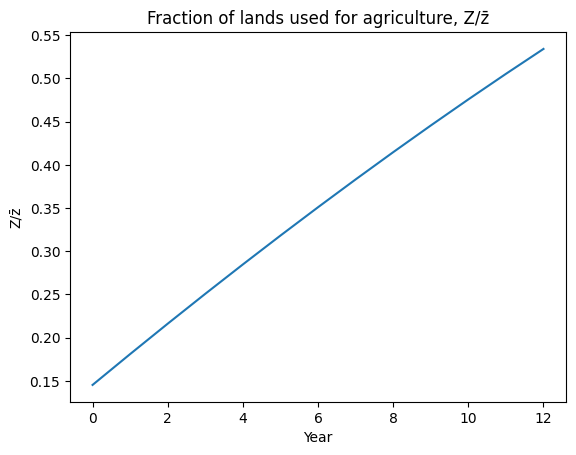

In [ ]:
plt.plot(x_history[0:n,:].T/z̄)
plt.xlabel('Year')
plt.ylabel('Z/z̄')
plt.title('Fraction of lands used for agriculture, Z/z̄')
plt.show()